<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/conv_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from IPython import display

In [4]:
!pip install wandb

display.clear_output()

In [5]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb

from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [6]:
%matplotlib inline

In [7]:
cifar_means = (0.49139968, 0.48215827, 0.44653124)
cifar_stds = (0.24703233, 0.24348505, 0.26158768)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_means, cifar_stds)])

In [9]:
BATCH_TRAIN = 4
BATCH_TEST = 4
WRKRS = 2
TOWHERE = './data'
SEED = 42
EPOCHS = 3
LR = 1e-4

In [10]:
WNB_FLAG = True
API_KEY = ''
WNB_PROJECT = 'custom_CIFAR10'
WNB_LOGIN = 'dimildizio'

In [11]:
def log_wnb(model, conf):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=conf)
    wandb.watch(model, log='all')

def log_step(name, iloss, accuracy):
  if WNB_FLAG:
      wandb.log({name+'_loss':iloss, 
          name+'_accuracy': accuracy})


In [12]:
trainset = datasets.CIFAR10(root = TOWHERE, train=True, download=True, transform = transform)
testset = datasets.CIFAR10(root = TOWHERE, train=False, download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_TRAIN, num_workers = WRKRS, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_TEST, num_workers = WRKRS, pin_memory = True, shuffle = False)

100%|██████████| 170498071/170498071 [00:10<00:00, 16895010.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [15]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEDD'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.determetistic = True
  torch.backends.cudnn.benchmark = False

seed_all(SEED)

In [16]:
def getnum():
  return np.random.randint(low=0, high=10000)

In [17]:
class MyCIFAR(nn.Module):
  def __init__(self):
    super(MyCIFAR, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def convolute(self, conv, x):
    convd = conv(x)
    activated = F.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


  def forward(self, x):
    x = self.convolute(self.conv1, x)
    x = self.convolute(self.conv2, x)
    x = self.flatten(x)
    x = self.fcs(x)
    return x


In [24]:
def getloss(netparam, y_pred, y, loss_fn, logitnorm = False):
  if logitnorm:
    y_pred = F.softmax(y_pred, dim=1)
    loss = loss_fn(y_pred, y)
    l2reg = torch.tensor(0.)
    for p in netparam:
      l2reg += torch.norm(p,p=2)
    loss += 0.001*l2reg
  else:
    loss = loss_fn(y_pred, y)
  return loss

In [25]:
def train(net, optimizer, loss_fn, normalize=False, epochs=EPOCHS):
  net.train()
  for epoch in range(epochs):
    curloss = 0.0
    correct=0
    total_samples = 0

    for i, batch in enumerate(tqdm_notebook(train_loader)):
      optimizer.zero_grad()
      X, y = batch
      y_pred = net(X)

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
      total_samples += y.size[0]

      loss = getloss(net.parameters(), y_pred, y, loss_fn, normalize)
      loss.backward()
      optimizer.step()
      curloss += loss.item()

      if not (i % int(train_loader.dataset.data.shape[0] / BATCH_TRAIN / 10)):
        print(f'Epoch: {epoch+1}, loss: {round(curloss, 3)}')
        curloss = 0.0
    log_step('train', loss, correct / total_samples)      

In [19]:
def eval_me(net):
  net.eval()
  iloss = nn.CrossEntropyLoss()
  class_correct = [0]*10
  class_total = [0]*10
  correct=0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      y_pred = net(images)
      
      loss = iloss(y_pred, labels)
      pred = y_pred.argmax(dim=1, keepdim=True)
      correct+= pred.eq(labels.view_as(pred)).sum().item()

      _, predicted = torch.max(y_pred,1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  results = []
  for i in range(10):
    result_i = 100 * class_correct[i] / class_total[i]
    results.append(result_i)
    print(f'Accuracy: {classes[i]}: {result_i}%')

  log_step('test', loss, correct / len(test_loader.dataset))
  

In [20]:
def visualize_result(idx, net):
    img = test_loader.dataset.data[idx]
    plt.imshow(img)
    
    image = transform(img)  
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')


In [22]:
def get_watch(net, optimizer=optim.Adam, lr=LR, epoch = EPOCHS):
  paramdict = {'epochs':epoch, 'train_batch':BATCH_TRAIN, 'num_workers':WRKRS, 
              'lr':lr, 'seed':SEED, 'classes':10}
  net = net()
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = optimizer(net.parameters(), lr=lr)

  log_wnb(net, paramdict)

  train(net, optimizer, loss_fn, epochs=epoch)
  eval_me(net)
  if WNB_FLAG:
    wandb.finish()

In [23]:
get_watch(MyCIFAR)

wandb: Currently logged in as: dimildizio. Use `wandb login --relogin` to force relogin


<ipython-input-18-72d1a018357e>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.306
Epoch: 1, loss: 2742.53
Epoch: 1, loss: 2550.142
Epoch: 1, loss: 2455.938
Epoch: 1, loss: 2328.173
Epoch: 1, loss: 2246.579
Epoch: 1, loss: 2198.961
Epoch: 1, loss: 2179.157
Epoch: 1, loss: 2175.758
Epoch: 1, loss: 2133.435


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 2087.54
Epoch: 2, loss: 2062.662
Epoch: 2, loss: 2029.431
Epoch: 2, loss: 2026.613
Epoch: 2, loss: 2032.325
Epoch: 2, loss: 1987.528
Epoch: 2, loss: 2001.535
Epoch: 2, loss: 1981.134
Epoch: 2, loss: 2006.757
Epoch: 2, loss: 1942.15


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1958.857
Epoch: 3, loss: 1907.627
Epoch: 3, loss: 1906.01
Epoch: 3, loss: 1878.934
Epoch: 3, loss: 1854.156
Epoch: 3, loss: 1894.2
Epoch: 3, loss: 1851.957
Epoch: 3, loss: 1893.257
Epoch: 3, loss: 1848.999
Epoch: 3, loss: 1816.076


TypeError: ignored

In [ ]:
net = MyCIFAR()
train(net, optim.Adam(net.parameters(), lr=LR, weight_decay=0.001), nn.CrossEntropyLoss(), normalize=True)
eval_me(net)

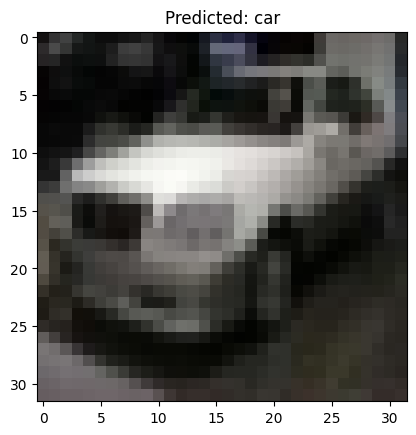

In [62]:
visualize_result(getnum(), net)

### Conditions: baseline\custom\logitnorm

> Batchsize:4\10\10

> Start loss: ~900\1100\1150

> End loss: ~400\760\1040


>>Accuracy: plane: 51.6% \ 62.1% \ 61.4%

>>Accuracy: car: 63.7% \ 56.1%  \ 50%

>>Accuracy: bird: 34.6% \ 44.2% \ 15.7%

>>Accuracy: cat: 53.8% \ 23.4% \ 17.8%

>>Accuracy: deer: 42.4% \ 37.5% \ 31.8%

>>Accuracy: dog: 0.0% \ 45.2% \ 22.7%

>>Accuracy: frog: 74.2% \ 71.9% \ 67.5%

>>Accuracy: horse: 66.9% \61.1% \ 52.3%

>>Accuracy: ship: 69.3% \ 0.0% \ 0.0%

>>Accuracy: truck: 55.8% \ 66.5% \ 64.5%


On this particular model looks like smaller batchsize (4) works better compared to larger (10). Also we've tested Alpha's logitnorm (used to fight overfitting) but in our case it worked worse even though it had been stated that l2 regularization and normalization of y_pred before putting it into loss function won't worsen the result.

Lets count the size for inputs one more time

1. Input image has 3 channels $32*32 = 32*32*3 =3072$ so the size is 3072
2. We retain the channels and calculate output size for **Width** and **Height** for first convolutions that is $Width^{out} = \frac{32-5 + 2*0}{1}+1 =28$ and $Height^{out} = \frac{32-5 + 2*0}{1}+1 =28$ 
3. We specified that or **out_channels=6** and **filter=5** so we've applied **six 5x5** filters to the image and resulted in **6(channels) * 28(width) * 28(height)** output
4. Apply max pooling stride=2 kernel=2 which lowers the dimensions to **6x14x14=1176**
5. For next convolution the out_channels=16 kernel=5 so for input 14x14 we take $Width^{out}=\frac{14-5+2*0}{1}+1=10$ and $Height^{out}=\frac{14-5+2*0}{1}+1=10$
6. The output is **16x10x10**
7. We dont do the pooling here and go straight to conv3
8. Third convolution makes **out_channels=32, kernel=5 for 10x10** input we get $Width^{out}=\frac{10-5+2*0}{1}+1=6$ and $Height^{out}=\frac{10-5+2*0}{1}+1=6$
9. And the output is **32x6x6**
10. Max pooling for stride=2 filter=2 makes it **32x3x3=288**
11. We perform the flattening which makes it **(288,)**
12. And the input size on the first fully-connected layer is **288** in our case
13. **288 -> 120 -> 84 -> 10** classes on output

In [35]:
class AnotherConv(nn.Module):
  def __init__(self):
    super(AnotherConv, self).__init__()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 5)

    self.fc1 = nn.Linear(288, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(self.conv3(F.relu(self.conv2(x))))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [36]:
net1 = AnotherConv()
train(net1, optim.Adam(net1.parameters(), lr=1e-3), nn.CrossEntropyLoss())
eval_me(net1)

<ipython-input-15-cb002da5c25a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1, loss: 2.318
Epoch: 1, loss: 2565.076
Epoch: 1, loss: 2322.286
Epoch: 1, loss: 2154.457
Epoch: 1, loss: 2062.91
Epoch: 1, loss: 2006.557
Epoch: 1, loss: 2015.204
Epoch: 1, loss: 1947.698
Epoch: 1, loss: 1905.088
Epoch: 1, loss: 1911.026


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 2, loss: 1878.941
Epoch: 2, loss: 1818.858
Epoch: 2, loss: 1828.221
Epoch: 2, loss: 1803.59
Epoch: 2, loss: 1820.035
Epoch: 2, loss: 1781.869
Epoch: 2, loss: 1790.227
Epoch: 2, loss: 1753.081
Epoch: 2, loss: 1764.283
Epoch: 2, loss: 1731.724


  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 3, loss: 1766.893
Epoch: 3, loss: 1660.189
Epoch: 3, loss: 1692.968
Epoch: 3, loss: 1643.979
Epoch: 3, loss: 1643.52
Epoch: 3, loss: 1660.219
Epoch: 3, loss: 1647.188
Epoch: 3, loss: 1643.849
Epoch: 3, loss: 1688.427
Epoch: 3, loss: 1638.0


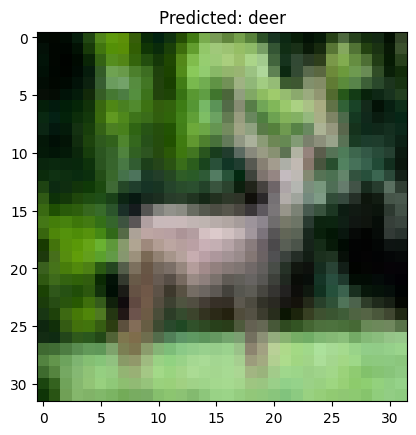

In [65]:
visualize_result(getnum(), net1)